In [1]:
import sys
sys.path.insert(0, '..')
from dhmc.dhmc_sampler import DHMCSampler

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

### Import functions to compute the posterior of the Jolly-Seber model based on the black-kneed capsid data from Seber (1982).

The functions 'f' and 'f_update' are used by DHMC and must have the structure as described below.


In [3]:
from data_and_posterior.jolly_seber_model import f, f_update

```python
def f(theta, req_grad=True):  
    """
    Computes the log posterior density and its gradient. 
    
    Params:
    ------
    theta : ndarray
    req_grad : bool
        If True, returns the gradient along with the log density.
    
    Returns:
    -------
    logp : float
    grad : ndarray
    aux : Any
        Any computed quantities that can be re-used by the 
        subsequent calls to the function 'f_updated' to save on
        computation.
    """
    
def f_update(theta, dtheta, j, aux):  
    """
    Computes the difference in the log conditional density 
    along a given parameter index 'j'.
    
    Params:
    ------
    theta : ndarray
    dtheta : float
        Amount by which the j-th parameter is updated.
    j : int
        Index of the parameter to update.
    aux : Any
        Computed quantities from the most recent call to functions
        'f' or 'f_update' that can be re-used to save on computation.
    
    Returns:
    -------
    logp_diff : float
    aux_new : Any
    """
```

The parameters "p", "phi", "U" are concatenated into a 1-d array for running DHMC. The dictionary "index" stores the linear indices used internally by 'f' and 'f_update'.

In [4]:
from data_and_posterior.jolly_seber_model \
    import pack_param, unpack_param, index

In [5]:
# Number of continuous and discrete parameters.
from data_and_posterior.jolly_seber_model \
    import n_param, n_disc, n_cont

### Pick an initial state for MCMC.

In [6]:
phi0 = .8 * np.ones(len(index["phi"]))
p0 = .15 * np.ones(len(index["p"]))
U0 = 500 * np.ones(len(index["U"]))
theta0 = pack_param(p0, phi0, U0)

### Initialize the DHMC sampler and test outputs of 'f' and 'f_update'.

In [7]:
scale = np.ones(n_param)
dhmc = DHMCSampler(f, f_update, n_disc, n_param, scale)

dhmc.test_cont_grad(theta0, sd=1, n_test=10);
_, theta, logp_fdiff, logp_diff = \
    dhmc.test_update(theta0, sd=10, n_test=10)

Test passed! The computed gradient seems to be correct.
Test passed! The logp differences agree.


### Run discontinuous HMC

In [8]:
seed = 1
n_burnin = 10 ** 2
n_sample = 1 * 10 ** 3
n_update = 10
dt = .025 * np.array([.8, 1])
nstep = [70, 85]

samples, logp_samples, accept_prob, pathlen_ave, time_elapsed = \
    dhmc.run_sampler(theta0, dt, nstep, n_burnin, n_sample, 
                     seed=seed, n_update=n_update)
dhmc_samples = samples[n_burnin:, :]

110 iterations have been completed.
220 iterations have been completed.
330 iterations have been completed.
440 iterations have been completed.
550 iterations have been completed.
660 iterations have been completed.
770 iterations have been completed.
880 iterations have been completed.
990 iterations have been completed.
1100 iterations have been completed.
The average path length of each DHMC iteration was 77.56.


### Check mixing with traceplots.
Note the substantial uncertainty and correlation in the capture probability $p_1$ and population size $N_1$ at the 1st capture occasion.

In [9]:
p_samples, phi_samples, U_samples, N_samples = \
    unpack_param(dhmc_samples)

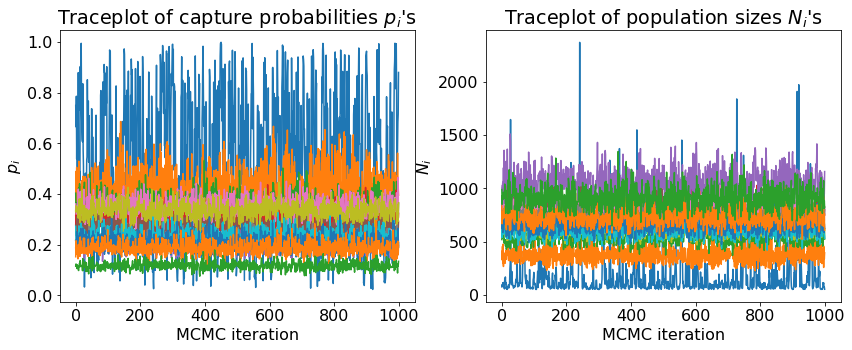

In [10]:
plt.figure(figsize=(14, 5))
plt.rcParams['font.size'] = 16

plt.subplot(1, 2, 1)
plt.plot(p_samples)
plt.title(r"Traceplot of capture probabilities $p_i$'s")
plt.ylabel(r"$p_i$")
plt.xlabel('MCMC iteration')

plt.subplot(1, 2, 2)
plt.plot(N_samples)
plt.title(r"Traceplot of population sizes $N_i$'s")
plt.ylabel(r"$N_i$")
plt.xlabel('MCMC iteration')

plt.show()

### NUTS-Gibbs sampler for comparison.

In [11]:
from data_and_posterior.jolly_seber_model import update_disc
from other_samplers.nuts_sampler import nuts

In [12]:
def nuts_gibbs(f, theta, dt, logp, grad, max_depth):
    def f_cond(theta_cont):
        logp, grad, _ = f(np.concatenate((theta_cont, theta[n_cont:])))
        if not np.any(np.isnan(grad)):
            grad = grad[:n_cont]
        return logp, grad
    theta_cont, logp, grad, nuts_accept_prob, nfevals = \
        nuts(f_cond, np.random.uniform(dt[0], dt[1]), theta[:n_cont], logp, grad, max_depth, warnings=False)
    theta[:n_cont] = theta_cont
    theta = update_disc(theta)
    logp, grad, _ = f(theta)
    grad = grad[:n_cont]    
    nfevals += 1
    return theta, logp, grad, nuts_accept_prob, nfevals

In [13]:
n_burnin = 10 ** 2
n_sample = 1 * 10 ** 3
n_update = 10
seed = 1

np.random.seed(seed)
    
# Pre-allocate
theta = theta0.copy()
n_per_update = math.ceil((n_sample + n_burnin) / n_update)
nfevals_total = 0
samples = np.zeros((n_sample + n_burnin, len(theta)))
logp_samples = np.zeros(n_sample + n_burnin)
accept_prob = np.zeros(n_sample + n_burnin)

# Run NUTS-Gibbs
logp, grad, _ = f(theta)
grad = grad[:n_cont]
for i in range(n_sample + n_burnin):
    theta, logp, grad, accept_prob[i], nfevals = \
        nuts_gibbs(f, theta, dt, logp, grad, max_depth=8)
    nfevals_total += nfevals + 1
    samples[i, :] = theta
    logp_samples[i] = logp
    if (i + 1) % n_per_update == 0:
        print('{:d} iterations have been completed.'.format(i+1))

nfevals_per_itr = nfevals_total / (n_sample + n_burnin)
print('The average NUTS path lenth was {:.2f}.'.format(nfevals_per_itr))

nuts_gibbs_samples = samples[n_burnin:, :]

110 iterations have been completed.
220 iterations have been completed.
330 iterations have been completed.
440 iterations have been completed.
550 iterations have been completed.
660 iterations have been completed.
770 iterations have been completed.
880 iterations have been completed.
990 iterations have been completed.
1100 iterations have been completed.
The average NUTS path lenth was 146.03.


### Check mixing with traceplots.

In [14]:
p_samples, phi_samples, U_samples, N_samples = \
    unpack_param(nuts_gibbs_samples)

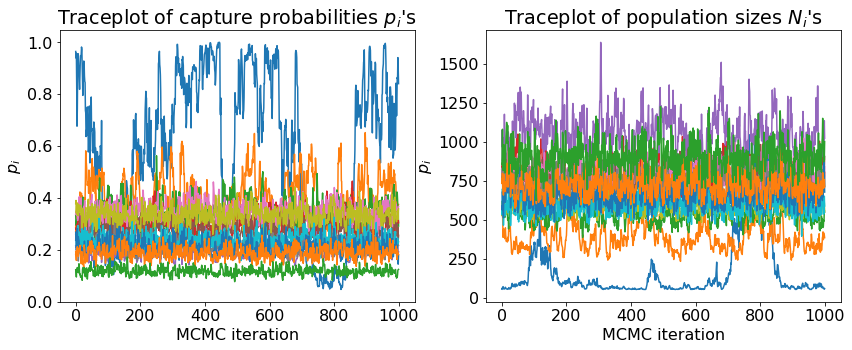

In [15]:
plt.figure(figsize=(14, 5))
plt.rcParams['font.size'] = 16

plt.subplot(1, 2, 1)
plt.plot(p_samples)
plt.title(r"Traceplot of capture probabilities $p_i$'s")
plt.ylabel(r"$p_i$")
plt.xlabel('MCMC iteration')

plt.subplot(1, 2, 2)
plt.plot(N_samples)
plt.title(r"Traceplot of population sizes $N_i$'s")
plt.ylabel(r"$p_i$")
plt.xlabel('MCMC iteration')

plt.show()